# Analysis 2
Jana Bruses | janabruses@pitt.edu | University of Pittsburgh | Apr 21st - Apr 29th

Second notebook of the Analysis portion of the project.\
First notebook found at: [Analysis-1-LowLevel](http://localhost:8888/notebooks/Linguistic-Markers-Catalan-Substitution/Analysis-1-LowLevel.ipynb)\
Fourth notebook of the project, after the [data portion](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Data-Parsing-Exploratory-Analysis-2.ipynb) notebook.

In this analysis notebook various machine learning models were used to:
1. Find if the texts can actually be classified in periods using Term Frequency - Inverse Document Frequency
2. Analyze the effectiveness of the selected linguistic markers that could indicate Catalan's substitution explored in [Analysis-1-LowLevel](http://localhost:8888/notebooks/Linguistic-Markers-Catalan-Substitution/Analysis-1-LowLevel.ipynb)

namely:

1. **"hi" percentage** - to analyze loss of word classes
2. **passat perifràstic vs passat simple** - to analyze time lexicon modification
3. **anar vs venir** percentage - to analyze space lexicon modification
4. **haver de vs tenir que** percentage - to analyze  syntactic restructuring
5. **verb pronominalization** - to analyze syntactic restructuring

Contents of this analysis notebook 2:\
**1** [Building a Naïve Bayes classifier using tf-idf features (pre-post Franquism)](#1.-Tf-Idf-Naive-Bayes-for-pre-vs-post-Franquism)\
**2** [Building a Naïve Bayes classifier using tf-idf features (3 periods)](#2.-Tf-Idf-Naive-Bayes-for-3-period-classification)\
**3** [Building a classifier using our linguistic features](#3.-Building-a-classifier-using-our-linguistic-features)\
**4** [Conclusion](#Conclusion)

In [1]:
# loading libraries
import pandas as pd
import numpy as np

All the data used in the analysis steps was included in the dataframe and pickled at the end of the analysis.\
The data will now be loaded.

In [2]:
# loading the pickled complete dataframe
tokscomplete_df = pd.read_pickle("data/tokcomplete_df.pkl")
tokscomplete_df = tokscomplete_df.drop_duplicates(subset="Text", keep="first")

## 1. Tf-Idf Naive Bayes for pre vs post Franquism

Our data, is split in two main periods, before Franquism and after Franquism. We have two blocks of data. From 1860 to 1926 and from 1985 to 2022. We will label this two periods as 1926b and 1985a and have a classifier distinguish them, to look for other features trough tf-idf, that could tell us more about Catalan's substitution.

In [3]:
def period2_tagger(year):
    if year <= 1926:
        return "1926b"
    elif year >= 1985:
        return "1985a"
    else:
        print(year) #printing any years not in that range to check

In [4]:
tokscomplete_df["Period2"] = tokscomplete_df["Year"].apply(period2_tagger)

In [5]:
tokscomplete_df["Period2"].value_counts()

Period2
1985a    64916
1926b       28
Name: count, dtype: int64

**Comment:**
As this numbers portray, we have a huge amount of data for the recent period, while we have very few documents for the period from 1926 and earler. However, since these are ceremonial speeches, looking at the length in tokens might actually be more informative. 

In [6]:
tokscomplete_df.groupby("Period2")["Len_toks"].sum()

Period2
1926b     143831
1985a    2803938
Name: Len_toks, dtype: int64

**Comment:** The gap is not as big as it was looking at file counts, as many of the later contributions are shorter, containing fewer tokens, while the few documents from before 1926 are complete speeches. 

Because of this, instead of having the classifier classify full pieces of text, we will use single sentences as the text features. 

In [7]:
def sent_tokenize(content):
    doc = nlp(content)
    sent_list = [sentence.text for sentence in doc.sentences]
    return sent_list

Since sentence tokenization through Stanza is a very demanding process that my laptop couldn't handle it was done using the pitt's CRC supercomputing. The following commented code corresponds to the files, using a very similar process as the function sent_tokenize above. The files in their respective extension can be found in [Scripts Folder](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/tree/main/scripts) as "sent_tok.py" and "sent_tok.sh".

In [8]:
python_code = """
import pandas as pd
import stanza

data_df = pd.read_pickle("lemmaComplete.pkl")
nlp = stanza.Pipeline(lang='ca', processors='tokenize')
mini_doc = nlp("Hola, com estas? Jo genial. I tu? Anem a fer una volta?")
print("sentences list:")
print([sent.text  for
        sent in nlp(mini_doc).sentences])
print()

data_df["Sent_toks"] = data_df["Text"].apply(lambda doc:
                                                        [sent.text  for
                                                        sent in nlp(doc).sentences])
data_df.to_pickle("sent_tok.pkl")
"""

In [9]:
slurm_file = """
#!/usr/bin/env bash

#SBATCH --job-name=proj_senttok
#SBATCH --output=sent_tok.out
#SBATCH --nodes=1
#SBATCH --ntasks=3
#SBATCH --partition=smp
#SBATCH --cluster=smp
#SBATCH --mem-per-cpu=16000
#SBATCH --time=180

module load python/ondemand-jupyter-python3.11
python sent_tok.py
"""

In [10]:
# reading the pickled dataframe with the new column containing the sentence tokens 
senttok_df = pd.read_pickle("data/sent_tok.pkl")

In [11]:
# looking at a couple examples
sent_tokens_example = senttok_df[senttok_df["Year"] == 1860]["Sent_toks"].iloc[0]
print(sent_tokens_example[0])
print()
print(sent_tokens_example[1])

Breu seré, cuant ja se han complagut vostres oídos ab los melodiosos cants de tants trovadors inspirats per lo esperit de la Religió, per lo amor de la patria y per lo amor á la bellesa ¿Qué podria jo anyadir cuant sento ja escapar de mon esperit la última espurna del juvenil entusiasme?

Tant sols me cap lo expressar ab curtas frases lo goig que inunda mon cor al véurervos per segona vegada reunits en aquesta festa de familia, renovant memorias tan dolsas, evocant noms tan estimats, y recordant dias tan gloriosos pera nostra antiga patria.


In [12]:
# re-doing the period tag on the sentence tokenized dataframe
senttok_df["Period2"] = senttok_df["Year"].apply(period2_tagger)

In [13]:
senttok_df["Sent_count"] = senttok_df["Sent_toks"].apply(lambda sents: len(sents))

In [14]:
senttok_df.groupby("Period2")["Sent_count"].sum()

Period2
1926b      2835
1985a    199697
Name: Sent_count, dtype: int64

In [15]:
# considering the total
senttok_df["Sent_count"].sum()

202532

In [16]:
# basline is incredibly high
199697/202532

0.986002211996129

**Comment:** We have a very big imbalance. One of the target groups of the 2 accounts for 98% of the data, which means that even if we tagged everything as that group, specifically "1985a" we would get 98% accuracy. Consequently, our classifier will need to be almost perfect either 99% or completely perfect to do better than the baseline.

In [17]:
# creating a function to tag the sentences
def tag_sents(sent_list, period2_tag):
    return ([(s, period2_tag) for s in sent_list])

In [18]:
# tagging the sentences
senttok_df["tagged_sents"] = senttok_df.apply(lambda row: tag_sents(row["Sent_toks"], row["Period2"]), axis=1)

In [19]:
# separating them into two lists
sents_1926b = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="1926b"]
sents_1985a = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="1985a"]

In [20]:
# checking a sentence from each of the lists to see the tag
print(sents_1926b[0])
sents_1985a[0]

("L'home que per amor al estudi, impulsat per un imperatiu ineludible 's manté reclòs en el seu laboratori o en la biblioteca, treballant sense parar may, indiferent a les temptacions mondanes, es certament un hèroe.", '1926b')


('perquè que el president de catalunya sigui rebut pel president de la comissió europea',
 '1985a')

In [21]:
# concatenating the two tagged sentence lists
sents = sents_1926b+sents_1985a

# randomizing the lists after concatenation
import random
random.Random(10).shuffle(sents)

In [22]:
# turning the tagged sents lists into a dataframe
tagged_df = pd.DataFrame(sents, columns=["sentence", "tag"])

In [23]:
# creating traning and testing partitions
from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(tagged_df["sentence"], tagged_df["tag"], test_size = 0.20, random_state = 0)

In [24]:
# examining resulting partitions 
print(len(docs_train), len(docs_test))
print(len(y_train), len(y_test))
print()
print(sorted(set(y_train)))
print(sorted(set(y_test)))

162025 40507
162025 40507

['1926b', '1985a']
['1926b', '1985a']


In [25]:
import sklearn
from sklearn.pipeline import make_pipeline

# for Naïve Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# will consist of 2 steps
# step 1: feature extraction through tf-idf
# step 2: naive bayes multinomial model
period2_nbc = make_pipeline(TfidfVectorizer(max_features = 1500), MultinomialNB())

# fitting and training model through pipeline 
period2_nbc.fit(docs_train, y_train) # fitting model (training sents, target labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=1500)),
                ('multinomialnb', MultinomialNB())])

In [26]:
# creating predicted labels
y_pred_prompt_nb = period2_nbc.predict(docs_test)

In [27]:
# evaluating
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [28]:
# checking accuracy score
accuracy_score(y_test, y_pred_prompt_nb)

0.9908904633767003

**Comment:** The performance is slightly better than if we just tagged everything as the most likely tag from the baseline which is 1985a. It has an accuracy of 99% compared to the baseline of 98%, which means that the tf-idf features do in fact help the classifier tag sentences as belonging to before 1926 or after 1985. 

Let's now take a look at where the errors are with a confusion matrix:

<function matplotlib.pyplot.show(close=None, block=None)>

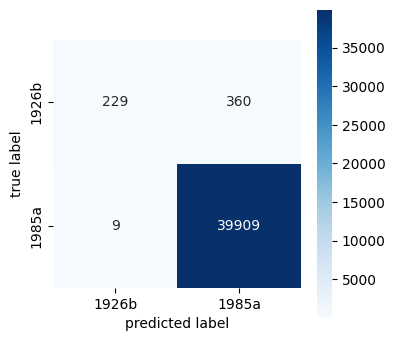

In [29]:
import matplotlib.pyplot as plt
mtrx_prompt_nb = confusion_matrix(y_test, y_pred_prompt_nb)
# plotting confusion matrix
plt.figure(figsize = (4, 4))
sns.heatmap(mtrx_prompt_nb, square = True, annot = True, fmt = 'd', cmap = "Blues", 
            xticklabels= sorted(set(y_train)), yticklabels= sorted(set(y_pred_prompt_nb)))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show

**Comment:** It seems like there are only 9 out of 39918 sentences that have been wrongly tagged as texts from after 1985 that were written before, which means that only 2 out of every 100 sentences are wrongly tagged into the after 1985 group but were written before 1925.\
For sentences written before 1926 out of 589 sentences 229 were wrongly tagged as written after 1985. This is about 38% of the sentences.\
This results are not surprising considering that we had a lot more sentences from the later period to train the classifier with.\
However, this matrix allows us to see why the model outperformed what tagging according to the baseline would give us. In that case all 39918 sentences written after 1985 would have been correctly tagged, so the 2% error wouldn't be present. However, none of the 589 sentences written before 1926 would have been correcly tagged, making it a bit worse in accuracy than the Naive Bayes classification with Tf-idf features. 

## 2. Tf-Idf Naive Bayes for 3 period classification

Next we will try to break down the time periods in smaller periods so that the baseline is not as high.

In [31]:
# looking were to break down the second, more data-extensive period
np.median([2022, 1985])

2003.5

**Comment:** Since we had a lot more data in the second period we will now break down the second and most recent time period in 2 shorter periods right down the median which is 2003.5, so we will do from 1985 to 2003 and from 2004 until 2022. We will kepp the period from before 1926 as a single time period.

In [32]:
# breaking down our data in:
# before 1926 (inclusive), between 1985 and 2004 (not ending inclusive), after 2004 (inclusive)
def period3_tagger(year):
    if year <= 1926:
        return "old"
    elif year >= 1985 and year < 2004:
        return "mid"
    elif year >= 2004:
        return "recent"
    else:
        print(year) #printing any years not in that range to check

In [33]:
senttok_df["Period3"] = senttok_df["Year"].apply(period3_tagger)

In [34]:
# tagging the sentences
senttok_df["tagged_sents"] = senttok_df.apply(lambda row: tag_sents(row["Sent_toks"], row["Period3"]), axis=1)

In [35]:
# creating a function to tag the sentences
def tag_sents(sent_list, period3_tag):
    return ([(s, period3_tag) for s in sent_list])

In [36]:
# separating them into two lists
sents_old = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="old"]
sents_mid = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="mid"]
sents_recent = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="recent"]

In [37]:
sents_recent[0]

('perquè que el president de catalunya sigui rebut pel president de la comissió europea',
 'recent')

In [38]:
# concatenating the two tagged sentence lists
sents = sents_old+sents_mid+sents_recent

# randomizing the lists after concatenation
import random
random.Random(10).shuffle(sents)

# turning the tagged sents lists into a dataframe
tagged_df = pd.DataFrame(sents, columns=["sentence", "tag"])

# creating traning and testing partitions
from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(tagged_df["sentence"], tagged_df["tag"], test_size = 0.20, random_state = 0)

# examining resulting partitions 
print(len(docs_train), len(docs_test))
print(len(y_train), len(y_test))
print()
print(sorted(set(y_train)))
print(sorted(set(y_test)))

162025 40507
162025 40507

['mid', 'old', 'recent']
['mid', 'old', 'recent']


In [39]:
# will consist of 2 steps
# step 1: feature extraction through tf-idf
# step 2: naive bayes multinomial model
period3_nbc = make_pipeline(TfidfVectorizer(max_features = 1500), MultinomialNB())

# fitting and training model through pipeline 
period3_nbc.fit(docs_train, y_train) # fitting model (training sents, target labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=1500)),
                ('multinomialnb', MultinomialNB())])

In [40]:
senttok_df.groupby("Period3")["Sent_count"].sum()

Period3
mid         3393
old         2835
recent    196304
Name: Sent_count, dtype: int64

In [41]:
# considering the total
senttok_df["Sent_count"].sum()

202532

In [42]:
# basline is still extremly high
196304/202532

0.9692493038137183

In [43]:
# creating predicted labels
y_pred_prompt_nb = period3_nbc.predict(docs_test)

# checking accuracy score
accuracy_score(y_test, y_pred_prompt_nb)

0.9762510183425087

<function matplotlib.pyplot.show(close=None, block=None)>

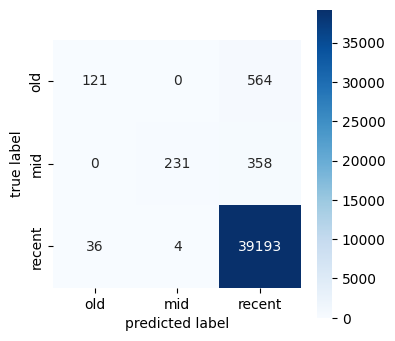

In [44]:
import matplotlib.pyplot as plt
labels = ["old", "mid", "recent"]
mtrx_prompt_nb = confusion_matrix(y_test, y_pred_prompt_nb)
# plotting confusion matrix
plt.figure(figsize = (4, 4))
sns.heatmap(mtrx_prompt_nb, square = True, annot = True, fmt = 'd', cmap = "Blues", 
            xticklabels= ("old", "mid", "recent"), yticklabels= ("old", "mid", "recent"))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show

It seems like while the model makes errors labeling recent sentence that we wouldn't make if we just labeled every sentence as "recent" as it is the most likely sentence with a 96.9%, misslaveling 2% of the recent sentences on the test set, the improvement in the "baseline performance" is in how the middle period and old sentences are tagged. There are no misslabels between mid and old sentences, which suggests that dividing the periods in the two groups cutting at 1926 and 1985 was the right point as the 2 groups "old" and "mid" are clearly differnciable. The biggest issue I find is that there are more misslabels between old and recent sentences both ways than between recent and mid any of the 2 ways, which suggests that mid and recent senetences are not as similar as I expected them to be and can indeed be better separated into two periods than I would I have thought. Hence, they don't really belong to the same period.
This 3 period devision model outperformed the previous 2 period model as it is closer to the 1% improvement from the baseline. 

## 3. Building a classifier using our linguistic features

Since our goal for this project is to see if the specific features can help us evaluate language substitution and we've looked for specific features, instead of using the tf-idf features, we will now use the percentages of these linguistic features as the features for time-period classification.

Also, since the 3 period classifier outperformed the 2 period one, we will now work with the same 3 periods. That is:\
Old - before 1926\
Mid - 1985-2003\
Recent - 2004-2022

In [45]:
# loading the complete dataframe
complete_df = pd.read_pickle("data/complete_df.pkl")

In [46]:
complete_df["tag3"]=complete_df["Year"].apply(period3_tagger)

In [47]:
# starting with 3 period division as it outperformed the 2 period division classification
from sklearn.model_selection import train_test_split
feat_train, feat_test, y_train, y_test = train_test_split(complete_df["Anar_percent"], complete_df["tag3"], test_size = 0.20, random_state = 0)

In [48]:
# examining resulting partitions 
print(len(feat_train), len(feat_test))
print(len(y_train), len(y_test))
print()
print(sorted(set(y_train)))
print(sorted(set(y_test)))

9674908 2418728
9674908 2418728

['mid', 'old', 'recent']
['mid', 'old', 'recent']


In [49]:
period3_nbc = make_pipeline(MultinomialNB())

In [50]:
feat_train = feat_train.values.reshape(-1, 1)
feat_test = feat_test.values.reshape(-1, 1)

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
clf = RandomForestClassifier(class_weight='balanced')

In [53]:
clf.fit(feat_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [54]:
# creating predicted labels
y_pred_prompt3_rf = clf.predict(feat_test)

# checking accuracy score
accuracy_score(y_test, y_pred_prompt3_rf)

0.24747718635580354

<function matplotlib.pyplot.show(close=None, block=None)>

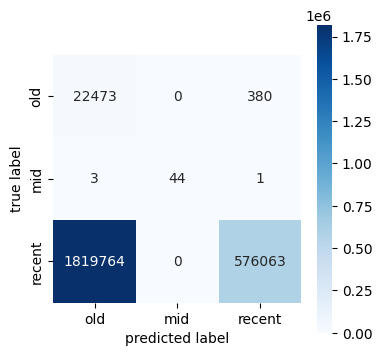

In [55]:
import matplotlib.pyplot as plt
labels = ["old", "mid", "recent"]
mtrx_prompt_nb = confusion_matrix(y_test, y_pred_prompt3_rf)

# plotting confusion matrix
plt.figure(figsize = (4, 4))
sns.heatmap(mtrx_prompt_nb, square = True, annot = True, fmt = 'd', cmap = "Blues", 
            xticklabels= ("old", "mid", "recent"), yticklabels= ("old", "mid", "recent"))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show

**Conclusions:**\
Even though the model only gets 24.5% accuracy, which is really bad and the confusion matrix shows us a very odd clasification pattern that doesn't even tell us much except from that it is very innacurate and the features don't seem to be useful at all to classify the texts.

In [56]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12093636 entries, 0 to 12093635
Data columns (total 29 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Year              int64  
 1   Line_id           object 
 2   Text              object 
 3   Text_len          int64  
 4   toks              object 
 5   Len_toks          int64  
 6   toks_low          object 
 7   hi                object 
 8   -hi               object 
 9   hi_count          int64  
 10  hi_percent        float64
 11  Lemmas            object 
 12  Anar_count        int64  
 13  Venir_count       int64  
 14  Anar_percent      float64
 15  Venir_percent     float64
 16  PstPerif          object 
 17  Pstp_count        int64  
 18  Pstp_percent      float64
 19  HaverDe_count     int64  
 20  TenirQue_count    int64  
 21  HaverDe_percent   float64
 22  TenirQue_percent  float64
 23  POS               object 
 24  PronominalizedV   object 
 25  PronV_count       int64  
 26  V_total     

## Conclusion

While the tf-idf classifier did outperfrom the baseline, our Random Forest model, trained with the linguistic features for language substitution that we were looking at had a terrible performance. This is not surprising considering that most of the features had no significant difference through time.\
The tf-idf performance is probably better than the baseline due to vocabulary differences and style, which are ultimetely not what we are looking at to see language substitution.
